Starting from September 7, 1940, the Germany's Luftwaffe bombed London indiscriminately for 56 of the following 57 nights in an attack that would come to be known as the Blitz. Citizens of London were instructed to not have any lights on after dark, so as to not give the Luftwaffe a target and, more importantly, conceal the location of critical infrastructure such as hospitals, barracks, and hangars. It became important, then, to determine from the locations of the bombs whether the Germans had found a way to locate these vital points of the city, or whether the attacks were purely random.

The following is a simulation of the events of the Blitz. The goal is firstly to demonstrate how hard it is for humans to tell the difference between random and targeted attacks and secondly to show how this problem can be solved quantitatively by considering the battlefield as a whole.

The first step to this is for the Blitz to happen. The following secretly decides whether the attacks will be uniformly random or targeted. Then the Luftwaffe, represented by a blue line, will sweep across London, represented by the chart, and drop some number of bombs, represented by red markers. In the aftermath, the user should make a prediction as to whether the Blitz was random or targeted, before carrying on to see how the answer can be found systematically.

<IPython.core.display.Javascript object>


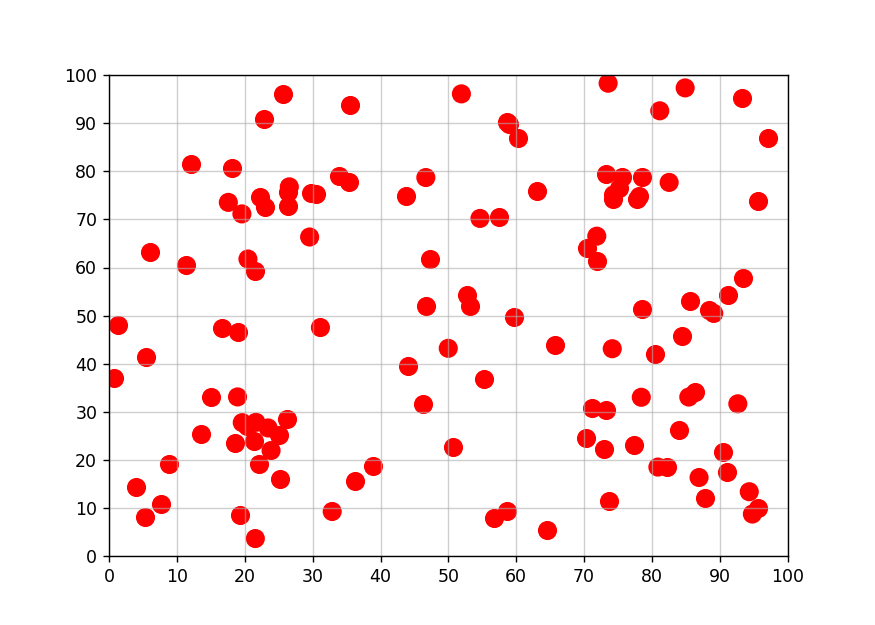

In [149]:
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import random as rd
import numpy as np
from math import sin, cos, tan, pi, e, factorial

XMIN, XMAX = 0,100
YMIN, YMAX = 0,100
mode = rd.sample(['Random', 'Targeted'], 1)[0]

NUM_HITS = 120
revealed_hits = []
if mode == 'Random': 
    hidden_hits = [(rd.randint(0, 100), rd.randint(0,100)) for i in range(NUM_HITS)]
else:
    t_min = 25
    t_max = 75
    targets = [(t_min,t_min), (t_min,t_max), (t_max,t_min), (t_max,t_max)]
    hidden_hits = []
    for i in range(NUM_HITS):
        target = rd.sample(targets, 1)[0]
        while True:
            r = np.random.normal(0,40)
            theta = np.random.uniform(0, 2*pi)
            xval = target[0] + r*cos(theta)
            yval = target[1] + r*sin(theta)
            if min(xval, yval) > 0 and max(xval, yval) < 100:
                break
        hidden_hits.append((xval, yval))
        
fig, ax = plt.subplots(figsize=(7,5))
plt.xlim(0,100)
plt.ylim(0,100)
attack_angle = np.random.uniform(0.01, 6.27)
slope = -1/tan(attack_angle)
normal = (np.sign(cos(attack_angle)), np.sign(cos(attack_angle))*tan(attack_angle))

if attack_angle < pi/2:
    xy0 = (100,100)
elif attack_angle < pi:
    xy0 = (0, 100)
elif attack_angle < 3*pi/2:
    xy0 = (0, 0)
else:
    xy0 = (100, 0)
xyf = tuple(map(lambda i,j: i-j, (100,100), xy0))
lastline = None

def gen():
    step_count = 0
    steps = 300
    while step_count < steps:
        yield step_count/steps
        step_count += 1
    yield step_count/steps
        
def advance(gen):
    t = gen
    xy1 = tuple(map(lambda i,j:  t*j+(1-t)*i, xy0, xyf))
    new_revealed = []
    for i in reversed(range(len(hidden_hits))):
        if np.dot(np.subtract(hidden_hits[i], xy1), normal) > 0:
            new_revealed.append(hidden_hits.pop(i))
    global lastline
    global revealed_hits
    if lastline is not None:
        lastline.remove()
    lastline = plt.axline(xy1, slope = slope)
    revealed_hits += new_revealed
    plt.scatter([hit[0] for hit in new_revealed], 
                [hit[1] for hit in new_revealed], 
                c = ['red']*len(new_revealed), 
                s = 100, 
                alpha = 1)

animation = FuncAnimation(fig, advance, gen, repeat=False, save_count=1, interval=1)

What do you think? Are the clusters of hits because the Germans know where to aim? Or is it just purely random chance?

The next step is to subdivide London in to some number of sections. In this example, we'll start with 100. The code below will add grid lines to the chart above to show how the city will be sectioned off. Notably, the drawing of the grid lines is, as it should be, agnostic to the actual hits. If the locations of the bombings inform the division of the city, the results may be skewed.

In [150]:
X_BOXES = 10
Y_BOXES = 10
NUM_BOXES = X_BOXES*Y_BOXES

ax.set_xticks(np.linspace(XMIN, XMAX, X_BOXES+1))
ax.set_yticks(np.linspace(YMIN, YMAX, Y_BOXES+1))
ax.grid(which="major",alpha=0.6)

To test objectively whether this attack was targeted or random, we now count how many sections recieved 0 hits, how many recieved 1 hit, and so on. If the attack was random, the results of this should follow a Poisson distribution with a mean equal to the total number of hits divided by the total number of sections. Let's take a look at how the chips fell after the above attack.

<IPython.core.display.Javascript object>


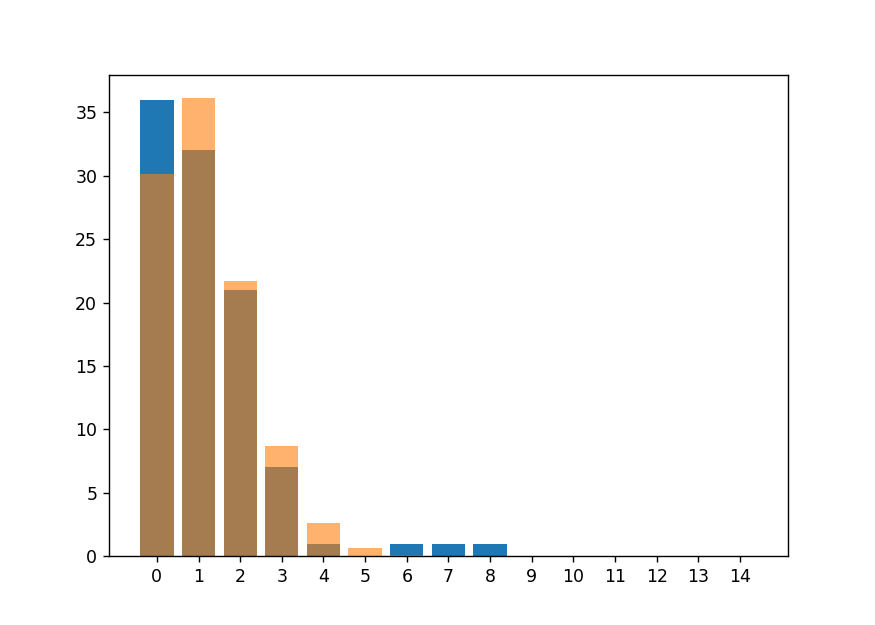

<BarContainer object of 15 artists>

In [151]:
X_WIDTH = (XMAX-XMIN)/X_BOXES
Y_WIDTH = (YMAX-YMIN)/Y_BOXES
def hit_in_box(hit, i):
    xmin = X_WIDTH*(i%X_BOXES)
    xmax = xmin + X_WIDTH
    ymin = Y_WIDTH*(i//X_BOXES)
    ymax = ymin + Y_WIDTH
    return xmin <= hit[0] < xmax and ymin <= hit[1] < ymax

l = NUM_HITS/NUM_BOXES
obs = {i:0 for i in range(15)}
for i in range(NUM_BOXES):
    count = len([j for j in range(len(revealed_hits)) if hit_in_box(revealed_hits[j], i)])
    obs[count] = obs.get(count, 0) + 1
names = sorted(list(obs.keys()))
vals = [obs[i] for i in names]
fig2 = plt.figure(figsize=(7,5))
plt.bar(range(len(names)), vals, tick_label=names)

For good measure, let's also take a look at what we would expect the distribution to be if the attack was uniformly random. The code below adds the expected distribution of hits to the graph above over top of the observed distribution.

In [152]:
exp = {i: NUM_BOXES*(l**i)*(e**(-l))/(factorial(i)) for i in names}
plt.bar(range(len(names)), [exp[i] for i in names], tick_label=names, alpha=0.6)

<BarContainer object of 15 artists>

This makes it a little easier to see, even for humans. But we should finish strong with a proper test. For example, we can run a chi square fit test to see how far the observed distribution is from the expected. For the sake of simplicity, I'll just display the p value of this test below. The closer the p value is to 0, the less likely we are to believe that the attack was not targeted. With that said, however, the p-value should always be considered in conjunction with other evidence.

In [153]:
from scipy.stats import chisquare
print("The p-value for this test is", chisquare(list(obs.values()), list(exp.values()), 1).pvalue)

The p-value for this test is 9.816217178448386e-70


How do you feel about your guess? Were you correct? Run the code below to reveal whether the attack was targeted or random. Thanks for playing!

In [154]:
print(mode)

Targeted
